# Predictive Modeling: Tanzanian Water Wells

## Business Understanding

### Overview

This project uses data on various water wells in Tanzania and attempts to build a predictive model that can discern between operational and non-operational water wells. The data contains information on each water well such as longitude, latitude, funder, management, pump type, and much more. The Tanzanian government can use this analysis and predictive model in order to decide where to allocate funding for water wells.

### Business Problem

Tanzania is a developing country with a population of over 57 million people. This country struggles to provide its large population with clean water. However, there are many water wells throughout the country. The Tanzanian government needs a way to predict if these water wells are operational or non-operational. Due to the nature of this problem, predicting a water well is operational when in reality it is not, is more costly than predicting a water well is non-operational when in reality it is. 
## Data Understanding

### Data Sources

The data used for this project comes from [DrivenData](https://www.drivendata.org/) and can be downloaded [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/).

## Data Preparation

### Data Cleaning

In [1]:
#Importing everything needed
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from missingpy import MissForest
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\rober\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Loading in the data as DataFrames
training_labels = pd.read_csv('Data/training_set_labels.csv')
training_values = pd.read_csv('Data/training_set_values.csv')

### Turning a Ternary Classification Problem into a Binary Classification Problem

`status_group` is the target group. As the data is given there are 3 possible values in this column:
1. functional
2. functional needs repair
3. non functional

According to the descriptions of these values, 'functional' and 'functional needs repair' are both considered to be operational while 'non functional' is considered non-operational. Therefore, it was decided to group 'functional' and 'functional needs repair' under operational. Leaving 'non functional' on its own and now labeled as non-operational.

In [3]:
training_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [4]:
#Changes the values in the 'status_group' column
training_labels['status_group'] = training_labels['status_group'].map({
                                                                        'non functional': 'non operational', 
                                                                        'functional': 'operational', 
                                                                         'functional needs repair': 'operational'})

### Merging `training_labels` with `training_values`

The data was downloaded in 2 different files. `training_labels` contains a unique identifier and the target column 'status_group'. `training_values` contains a matching unique identifier column along with the rest of the data. The data needs to be merged in order to perform a proper train/test split later.

In [5]:
#Showing a preview of 'training_labels' after the values have been changed
training_labels.head()

,id,status_group
0,69572,operational
1,8776,operational
2,34310,operational
3,67743,non operational
4,19728,operational


In [6]:
#Showing a preview of 'training_values'
training_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,Country
0,69572,6000.0,3/14/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,Tanzania
1,8776,0.0,3/6/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Tanzania
2,34310,25.0,2/25/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,Tanzania
3,67743,0.0,1/28/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,Tanzania
4,19728,0.0,7/13/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Tanzania


In [7]:
#Merging on the two DataFrames on 'id'
df = training_values.merge(training_labels, on='id')

### Dropping Unnecessary/Unusable Columns
These columns were dropped because they either had too many null values, placeholder values, or was missing information to give the values meaning.

In [8]:
#Dropping the unique identifier column
df.drop("id", axis = 1,inplace=True)

In [9]:
#Creating a list of all the columns to drop from the DataFrame
columns_to_drop = ["amount_tsh", "num_private", "recorded_by", "payment_type", "extraction_type", "extraction_type_group", 
                   "water_quality", "quantity_group", "scheme_name"]
#Dropping all the columns from the DataFrame using the list above
df_small = df.drop(columns_to_drop, axis = 1)

### Replacing all Placeholder Values with Null Values

There were many columns with placeholder values such as 0 or 'none'. These were replaced with null values in order to be imputed later.

In [10]:
#Replacing all placeholder values with null values
df_small_small = df_small.replace({'none': None,'unknown' : None, -2.00E-08: None, "0": None})
df_small_small["district_code"].replace({0: None}, inplace=True)
df_small_small["population"].replace({0: None}, inplace=True)
df_small_small["construction_year"].replace({0: None}, inplace=True)

Decided it is not a good idea to impute values for longitude or latitude and there are some null values in the latitude column. It is not a large amount of data lost if theses nulls are removed from the data so they were removed.

In [11]:
#Finding the amount of nulls in the latitude column
df_small_small['latitude'].isna().sum()

1812

In [12]:
#Dropping the nulls from latitude
df_small_small.dropna(subset=['latitude'],inplace=True)

### Preparing Data for Imputation
MissForest is the imputer used for this project. MissForest can handle categorical data but the values must be numbers. Strings will not pass through the imputer. There is a lot of categorical data with strings as values. We created a function that turns these strings into an integer that corresponds to its rank in a .value_counts() in order to pass it through the MissForest imputer.

In [13]:
df_small_small.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,...,payment,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,Country,status_group
0,3/14/2011,Roman,1390,Roman,34.938093,-9.856322,None,Lake Nyasa,Mnyusi B,Iringa,...,pay annually,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,Tanzania,operational
1,3/6/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,...,never pay,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Tanzania,operational
2,2/25/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,...,pay per bucket,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,Tanzania,operational
3,1/28/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,...,never pay,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,Tanzania,non operational
4,7/13/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,...,never pay,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Tanzania,operational


In [14]:
# this function takes columns from the df and turns the value into numbers in order to impute nulls with MissForest
def transform_columns(dataframe, columns):
    #creating new df that will have integers instead of strings for values
    transformed_df = pd.DataFrame()
    
    #loops through each column in the df given and assigns the strings an integer based off the rank in .value_counts()
    for column in columns:
        unique_vals = dataframe[column].value_counts().index
        string_to_numbers = dataframe[column].replace(to_replace=unique_vals, value=list(range(len(unique_vals))))
        transformed_df[column] = string_to_numbers
        
    return transformed_df

### Using the Function

Running the function in the cell below takes a few minutes so we saved it as a .csv file in order to quickly access it.
The below cell is commented out but shows where `transformed_df` is coming from and can be ran if needed.

In [15]:
# #Using the function above on all categorical columns

# transformed_df = transform_columns(df_small_small, ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 
#                                                     'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 
#                                                     'scheme_management', 'permit', 'extraction_type_class',
#                                                     'management', 'management_group', 'payment', 'quality_group', 
#                                                     'quantity', 'source', 'source_type', 'source_class','waterpoint_type',
#                                                     'waterpoint_type_group', 'status_group'])

In [16]:
# transformed_df.to_csv('Dev_Notebooks/working_df.csv')

### .csv File

working_df.csv is the file saved from `transformed_df`

In [17]:
#Loading in working_df.csv as transformed_df
transformed_df = pd.read_csv('Dev_Notebooks/working_df.csv', index_col = 0)
transformed_df

,funder,installer,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,...,source_class,waterpoint_type,waterpoint_type_group,status_group,date_recorded,construction_year,gps_height,longitude,latitude,population
0,33.0,87.0,NaN,6,1448.0,0,0,4.0,35,535,...,0.0,0,0,0,2011,1999.0,1390,34.938093,-9.856322,109.0
1,132.0,160.0,1.0,1,2096.0,14,14,1.0,20,130,...,1.0,0,0,0,2013,2010.0,1399,34.698766,-2.147466,280.0
2,432.0,15.0,1502.0,0,0.0,18,17,3.0,79,1559,...,1.0,3,0,0,2013,2009.0,686,37.460664,-3.821329,250.0
3,7.0,30.0,31378.0,7,252.0,17,20,14.0,108,623,...,0.0,3,0,1,2013,1986.0,263,38.486161,-11.155298,58.0
4,1788.0,58.0,0.0,1,7757.0,6,5,0.0,17,1360,...,1.0,0,0,0,2011,NaN,0,31.130847,-1.825359,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,13.0,9.0,11009.0,0,3166.0,2,2,4.0,31,31,...,0.0,0,0,0,2013,1999.0,1210,37.169807,-3.253847,125.0
59396,244.0,306.0,16398.0,2,364.0,0,0,3.0,0,267,...,1.0,0,0,0,2011,1996.0,1212,35.249991,-9.070629,56.0
59397,NaN,NaN,140.0,2,8761.0,1,1,6.0,30,70,...,0.0,1,1,0,2011,NaN,0,34.017087,-8.750434,NaN
59398,692.0,583.0,32017.0,2,156.0,12,11,3.0,71,833,...,0.0,1,1,0,2011,NaN,0,35.861315,-6.378573,NaN


### Combining all Columns into `transformed_df`

Now that the categorical columns have been changed to numbers, the numerical columns can be merged back into the same DataFrame.

In [18]:
#
transformed_df['date_recorded'] = pd.to_datetime(df_small_small['date_recorded'])
transformed_df['date_recorded'] = transformed_df['date_recorded'].dt.year
#Adding all numerical columns onto 'transformed_df'
transformed_df['construction_year'] = df_small_small['construction_year']
transformed_df['gps_height'] = df_small_small['gps_height']
transformed_df['longitude'] = df_small_small['longitude']
transformed_df['latitude'] = df_small_small['latitude']
transformed_df['population'] = df_small_small['population']

### The Data is Clean and Ready for Train/Test Split

For the split the target column is 'status_group' and will be used for `y`. All other columns will be used as featues and will be set to `X`. A random state of 33 is used and a test size slightly larger than defualt at 0.3.

In [19]:
#Splitting the column into the target and features
X = transformed_df.drop('status_group', axis=1)
y = transformed_df['status_group']

#Creating the 4 different groups resulting from a train/test split with a test size of 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.3)

### Now the Data is Split, It's Time for the Imputer


In [20]:
#Instantiate the MissForest
imputer = MissForest(random_state=33, max_depth=1)

### Imputing `X_train`

Running this takes a long time so it was saved as a .csv file for quick access. So this cell is commented out but can be ran if needed.

In [21]:
# #The cat_vars parameter is telling MissForest which columns are categorical

# X_train_imputed = imputer.fit(X_train, cat_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
# X_train_imputed = pd.DataFrame(imputer.transform(X_train))

In [22]:
# #Writing data to csv
# X_train_imputed.to_csv('Dev_Notebooks/X_train_imputed.csv')

In [23]:
#Loading in the saved .csv file as X_train_imputed
X_train_imputed = pd.read_csv('Dev_Notebooks/X_train_imputed.csv', index_col = 0)
X_train_imputed

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,16.0,159.0,21423.0,5.0,25.0,12.0,11.0,4.0,68.0,328.0,...,2.0,0.0,3.0,0.0,2011.0,1998.387233,0.0,35.891855,-6.153545,330.710809
1,12.0,2.0,20170.0,4.0,17999.0,7.0,7.0,0.0,12.0,65.0,...,0.0,0.0,0.0,0.0,2013.0,1993.000000,1260.0,30.914468,-3.326810,530.000000
2,12.0,50.0,3491.0,8.0,8280.0,16.0,15.0,3.0,103.0,968.0,...,3.0,1.0,0.0,0.0,2013.0,1984.000000,2137.0,31.631254,-7.863417,750.000000
3,1.0,4.0,14465.0,6.0,10407.0,8.0,8.0,2.0,18.0,412.0,...,0.0,0.0,0.0,0.0,2013.0,1992.000000,462.0,34.831606,-11.319762,96.000000
4,0.0,0.0,10655.0,2.0,7213.0,3.0,3.0,3.0,27.0,475.0,...,1.0,0.0,1.0,1.0,2011.0,1976.000000,295.0,36.624641,-8.410004,400.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40306,1352.0,0.0,35059.0,0.0,159.0,10.0,9.0,4.0,80.0,802.0,...,2.0,0.0,0.0,0.0,2011.0,1995.000000,52.0,38.973581,-5.375739,12.000000
40307,28.0,59.0,2.0,0.0,8.0,2.0,2.0,2.0,11.0,513.0,...,3.0,1.0,0.0,0.0,2013.0,2013.000000,500.0,38.078320,-4.480761,140.000000
40308,392.0,2.0,20502.0,5.0,2370.0,3.0,3.0,5.0,25.0,539.0,...,3.0,1.0,0.0,0.0,2011.0,1985.000000,520.0,37.560400,-6.917776,1.000000
40309,1.0,4.0,32490.0,2.0,214.0,8.0,8.0,4.0,21.0,681.0,...,3.0,1.0,3.0,0.0,2013.0,1982.000000,844.0,36.122400,-10.463274,250.000000


### Need Column Names

The imputer took care of the null values but the column names were lost in the process.

In [24]:
#Renaming all the columns
X_train_imputed.rename(columns={'0': 'funder', '1': 'installer', '2': 'wpt_name', '3': 'basin', '4': 'subvillage',
                                  '5': 'region', '6': 'region_code', '7': 'district_code', '8': 'lga', '9': 'ward',
                                  '10': 'public_meeting', '11': 'scheme_management', '12': 'permit',
                                  '13': 'extraction_type_class', '14': 'management', '15': 'management_group', '16': 
                                  'payment', '17': 'quality_group', '18': 'quantity', '19': 'source', '20': 'source_type',
                                  '21': 'source_class', '22': 'waterpoint_type', '23': 'waterpoint_type_group', '24': 
                                  'date_recorded', '25': 'gps_height', '26': 'longitude', '27': 'latitude', '28': 'population',
                                  '29': 'construction_year'}, inplace=True)

### Change All Categorical Columns Back to Strings

The numbers in all of the categorical columns don't make any sense right now but we can turn them back to what they were.

In [25]:
def revert_back_to_strings(df, columns):
    #Creates a copy of the DataFrame so it isn't overwriting the original
    df_copy = df.copy()
    
    #looping through all columns given and changes the number back to the string it represents based off a dictionary zipped
    #from one list of the .value_counts() from df_small_small and another list that creates an index of the first
    for col in columns:
        column_vc = list(df_small_small[col].value_counts().index)
        column_rank = list(range(len(column_vc)))
    
        column_vc_rank = dict(zip(column_rank, column_vc))
    
        df_copy[col] = df_copy[col].replace(column_vc_rank)
    
    return df_copy

### Creating a List of Columns to Feed the Function

In [26]:
#Creating a list of all column names in X_train_imputed
revert_columns = list(X_train_imputed.columns)
#Only taking the categorical columns from that list
revert_columns = revert_columns[:24]

### Using the Function

In [27]:
#Using the function on all categorical columns in X_train_imputed
# X_train_imputed = revert_back_to_strings(X_train_imputed, revert_columns)
# X_train_imputed

### Imputing `X_test`

This is commented out because it takes a long time to run. It was saved as a .csv file for easier access but can be ran if needed.

In [28]:
# X_test_imputed = pd.DataFrame(imputer.transform(X_test))



In [29]:
# X_test_imputed.to_csv('Dev_Notebooks/X_test_imputed.csv')

### Loading in `X_test_imputed`

Loading in data from .csv

In [30]:
X_test_imputed = pd.read_csv('Dev_Notebooks/X_test_imputed.csv', index_col=0)


In [31]:
#Renaming all the columns
X_test_imputed.rename(columns={'0': 'funder', '1': 'installer', '2': 'wpt_name', '3': 'basin', '4': 'subvillage',
                                  '5': 'region', '6': 'region_code', '7': 'district_code', '8': 'lga', '9': 'ward',
                                  '10': 'public_meeting', '11': 'scheme_management', '12': 'permit',
                                  '13': 'extraction_type_class', '14': 'management', '15': 'management_group', '16': 
                                  'payment', '17': 'quality_group', '18': 'quantity', '19': 'source', '20': 'source_type',
                                  '21': 'source_class', '22': 'waterpoint_type', '23': 'waterpoint_type_group', '24': 
                                  'date_recorded', '25': 'gps_height', '26': 'longitude', '27': 'latitude', '28': 'population',
                                  '29': 'construction_year'}, inplace=True)

### Using `revert_back_to_strings` Function for `X_test_imputed`

In [32]:
# X_test_imputed = revert_back_to_strings(X_test_imputed, revert_columns)
# X_test_imputed

## Modeling - Logistic Regression

Logistic regression was the first model that we evaluated.

In [33]:
#Imports for modeling
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix, make_scorer
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, plot_roc_curve

### Scaling `x_train_imputed` and `x_test_imputed`

First we scale all of our 'X' values as Logisitc Regression uses regularaization by default.

In [34]:
#Instante 'StandardScaler', fit and transform the X data.
ss = StandardScaler()
X_train_imputed_sc = ss.fit_transform(X_train_imputed)
X_test_imputed_sc = ss.transform(X_test_imputed)

### Baseline Model

Here we fit the default logisitc regression model to our training data.

In [35]:
#Instantiate basline Logistic Regression model
logreg = LogisticRegression(random_state=33)
logreg.fit(X_train_imputed_sc, y_train)

LogisticRegression(random_state=33)

### Confusion Matrix

Plotting a confusion matrix to get a better visual of our predictions and metrics. We then run a preliminary precision score.

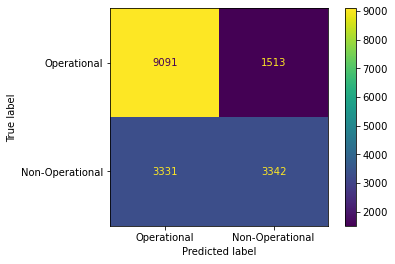

In [36]:
#Plot confusion matrix
plot_confusion_matrix(logreg, X_test_imputed_sc, y_test, 
                      display_labels=['Operational', 'Non-Operational']);

In [37]:
#Precision score using y_test predictions
y_test_pred = logreg.predict(X_test_imputed_sc)
#Using 'pos_label' bc positive variable corresponds to '0' not '1'
precision_score(y_test, y_test_pred, pos_label=0)

0.7318467235549831

***Our initial Logistic Regression precision score without any tuning is .7308. Next step is to tune the model to improve the precision score.**

### Tuning the Logistic Regression Model

Our 'positive' variable corresponds to '0' and not '1' in our target column data. We need the model to pick up on this to have an accurate precision score so we instantiate a new 'scorer' that identifies '0' as positive rather than negative.

In [38]:
#Instantiate new scorer using 'make_scorer'
scorer = make_scorer(precision_score, pos_label=0)

We use 'GridSearchCV' to optimize the parameters of our model.

In [39]:
#Instantiate 'GridSearchCV' and list of parameters
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
    'solver' : ['lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter' : [100, 1000, 10000],    
}
clf = GridSearchCV(logreg, param_grid, cv=5, scoring=scorer)

In [40]:
#Fit the grid search to our training data
clf.fit(X_train_imputed_sc, y_train)
print(clf.best_params_)

KeyboardInterrupt: 

In [41]:
#Pass in the best parameters to new logistic regression 
logreg2 = LogisticRegression(random_state=33, C = 0.1, max_iter = 100, solver= 'liblinear' )

#Fit the new model to training data
logreg2.fit(X_train_imputed_sc, y_train)

LogisticRegression(C=0.1, random_state=33, solver='liblinear')

### Cross Validation

Here we cross-validate our training data and return our tuned model's precision score.

In [42]:
#Use 'cross_val_score' on training data to return corresponding precision score
cv_results = cross_val_score(estimator=logreg2, X=X_train_imputed_sc, y=y_train, cv=5, scoring=scorer)
cv_results

array([0.73132509, 0.73180546, 0.73314898, 0.73078971, 0.72828741])

In [43]:
#Precision score using test data and test predictions
y_test_pred = logreg2.predict(X_test_imputed_sc)
precision_score(y_test, y_test_pred, pos_label=0)

0.7319703799098519

In [44]:
#Use 'calassification_report' to summarize our scores
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79     10604
           1       0.69      0.50      0.58      6673

    accuracy                           0.72     17277
   macro avg       0.71      0.68      0.68     17277
weighted avg       0.72      0.72      0.71     17277



### Calculate ROC-AUC on test data

Using our imputed test data we calculate our prediced probabilites to return our ROC-AUC score. We then plot the ROC curve.

In [45]:
#Predict our test probabilities
probas = logreg2.predict_proba(X_test_imputed_sc)[:, 1]
#Return the roc-auc score
roc_auc_score(y_test, probas)

0.7686092403088436

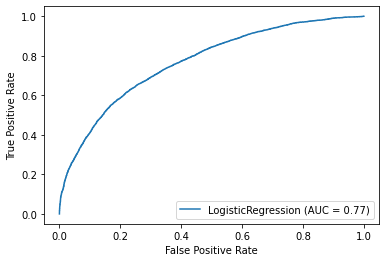

In [46]:
#Plot the ROC curve
plot_roc_curve(logreg2, X_test_imputed_sc, y_test);

### Evaluating our Logisitc Regression Model:
- Our precision score was not bad, precision = .073.
- We wanted to evalaute other models to see if they would perform better.
- We chose to run a Decision Tree model and compare results.

## Modeling - Decision Tree

Baseline model

In [47]:
#Instantiate decision tree classifier and fit to our data
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_imputed, y_train)

DecisionTreeClassifier(random_state=42)

In [48]:
#untuned score
precision_score(y_test, tree.predict(X_test_imputed), pos_label=0)

0.8423573103987491

# Hyperparameter Tuning
We use 'GridSearchCV' to optimize the parameters of our model

In [49]:
# hyperparameters to search over
parameters = {'max_depth': [38, 40, 42, 44, 46, 47],  'min_samples_leaf': [1, 2, 3, 4], 'min_samples_split': [2, 4, 6, 8]}

# cross-validate to tune parameters
search = GridSearchCV(tree, parameters, cv=5, scoring = scorer)
search.fit(X_train_imputed, y_train)

#best parameters and associated score 
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

Best hyperparameters: {'max_depth': 38, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.8362041833913805


In [50]:
#Tree with tuned parameters
tuned_tree = DecisionTreeClassifier(random_state=42, max_depth= search.best_params_['max_depth'], 
                                    min_samples_leaf = search.best_params_['min_samples_leaf'], 
                                    min_samples_split = search.best_params_['min_samples_split'])
tuned_tree.fit(X_train_imputed, y_train)

DecisionTreeClassifier(max_depth=38, random_state=42)

In [51]:
#Use 'cross_val_score' on training data to return corresponding precision score
cv_results = cross_val_score(estimator=tuned_tree, X=X_train_imputed, y=y_train, cv=5, scoring=scorer)
cv_results

array([0.83299389, 0.84396871, 0.83845044, 0.826819  , 0.83878887])

In [52]:
#Use 'calassification_report' to summarize our scores
print(classification_report(y_test, tuned_tree.predict(X_test_imputed)))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83     10604
           1       0.72      0.76      0.74      6673

    accuracy                           0.79     17277
   macro avg       0.78      0.79      0.78     17277
weighted avg       0.79      0.79      0.79     17277



Our baseline model preformed as well or better than our tuned model

In [53]:
#Use 'cross_val_score' on training data to return corresponding precision score
cv_results = cross_val_score(estimator=tree, X=X_train_imputed, y=y_train, cv=5, scoring=scorer)
cv_results

array([0.83045334, 0.84025363, 0.83742521, 0.82633053, 0.83878887])

In [54]:
#Use 'calassification_report' to summarize our scores
print(classification_report(y_test, tree.predict(X_test_imputed)))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83     10604
           1       0.72      0.76      0.74      6673

    accuracy                           0.79     17277
   macro avg       0.78      0.79      0.78     17277
weighted avg       0.79      0.79      0.79     17277



In [57]:
X_test_imputed.columns

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'public_meeting',
       'scheme_management', 'permit', 'extraction_type_class', 'management',
       'management_group', 'payment', 'quality_group', 'quantity', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'date_recorded', 'gps_height', 'longitude',
       'latitude', 'population', 'construction_year'],
      dtype='object')

In [55]:
importance = tuned_tree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.02530
Feature: 1, Score: 0.02779
Feature: 2, Score: 0.06087
Feature: 3, Score: 0.00396
Feature: 4, Score: 0.06064
Feature: 5, Score: 0.00844
Feature: 6, Score: 0.00536
Feature: 7, Score: 0.01194
Feature: 8, Score: 0.02439
Feature: 9, Score: 0.04090
Feature: 10, Score: 0.00254
Feature: 11, Score: 0.00607
Feature: 12, Score: 0.00422
Feature: 13, Score: 0.02401
Feature: 14, Score: 0.01559
Feature: 15, Score: 0.00416
Feature: 16, Score: 0.02268
Feature: 17, Score: 0.00583
Feature: 18, Score: 0.17415
Feature: 19, Score: 0.01417
Feature: 20, Score: 0.01055
Feature: 21, Score: 0.00270
Feature: 22, Score: 0.08485
Feature: 23, Score: 0.00915
Feature: 24, Score: 0.00160
Feature: 25, Score: 0.05989
Feature: 26, Score: 0.04696
Feature: 27, Score: 0.09740
Feature: 28, Score: 0.10079
Feature: 29, Score: 0.04309


### Evaluating our Final Decision Tree Model:
- Our final precision score of .842 is good epically for an untuned model
- This is in part thanks to our use of an imputer